# CNN auto-supervisé sur MNIST

# Importer les libraires

In [12]:

# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.datasets import mnist
from keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from keras.models import Sequential, load_model, Model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Lambda, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow import distribute, config
from sklearn.metrics import classification_report

# I. Prétraitement de données

## I.I. Normalisation de données

In [14]:
# Charger le dataset
(X_train, y_train), (X_test, y_test)=mnist.load_data()

# Normaliser le dataset
X_train=X_train/255
X_test=X_test/255

# Créer l'ensemble de validation et de test
X_val=X_test[:5000]
y_val=y_test[:5000]

X_test=X_test[5000:]
y_test=y_test[5000:]

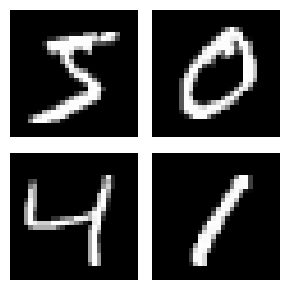

In [18]:
image = X_train[range(4)]

plt.figure(figsize=(3, 3))

plt.subplot(221)
plt.imshow(image[0], cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(222)
plt.imshow(image[1], cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(223)

plt.imshow(image[2], cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(224)

plt.imshow(image[3], cmap='gray', interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()


## I.II. Création du sous-ensemble des 100 données annotées et le reste non-annoté

In [4]:
indices_labeled = []
# Choisir 10 indices aléatoire de chaque classes
for i in range(10):
    indices_labeled.extend(np.where(y_train == i)[0][:10]) #Prendre les indices des dix premiers éléments X de chaque classe

X_labeled=np.array(X_train[indices_labeled]) # Créer l'ensemble des 100 labeled avec 10 élément de chauqe classe
y_labeled=np.array(y_train[indices_labeled])

indices_unlabeled = np.setdiff1d(np.arange(len(X_train)),indices_labeled) #Exclure l'ensemble des 59900 unlabeled
X_unlabeled=np.array(X_train[indices_unlabeled])
y_unlabeled=np.array(y_train[indices_unlabeled])

## I.III. Création des données de pré-entrainement

### Création des X : I.III.I. Transformation des images par rotations

In [6]:
# X_train_0 contient les images par rotation de 0 degrés(No rotation)
X_train_0=X_unlabeled.copy()

# X_train_90 contient les images par rotation de 90 degrés
X_train_90=np.rot90(X_unlabeled, axes=(1,2))

# X_train_180 contient les images par rotation de 180 degrés
X_train_180=np.rot90(X_unlabeled, 2, axes=(1,2))

# X_train_270 contient les images par rotation de 2700 degrés
X_train_270=np.rot90(X_unlabeled, 3, axes=(1,2))


### I.III.II. Création des y : Pseudo-annotation du dataset de pré-entrainement

In [7]:
# Affecter des pseudo-labels des images
y_train_0=np.full((59900), 0)
y_train_90=np.full((59900), 1)
y_train_180=np.full((59900), 2)
y_train_270=np.full((59900), 3)

In [8]:
# Concaténer les datasets
X_train_unlabeled_full=np.concatenate((X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
y_train_unlabeled_full=np.concatenate((y_train_0, y_train_90, y_train_180, y_train_270), axis=0)

In [9]:
# La fonction répartira uniformément les échantillons sur l'ensemble du jeu de données.
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

### I.III.III. Création de l'ensemble d'entraînement

In [10]:
# Mélanger aléatoirement le jeu de données concaténé.
X_train_unlabeled_full_shuffled, y_train_unlabeled_full_shuffled = unison_shuffled_copies(X_train_unlabeled_full, y_train_unlabeled_full)

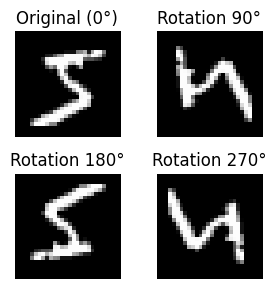

In [16]:

index = 0  
image = X_train[index]

rotated_0 = image
rotated_90 = np.rot90(image, k=1)
rotated_180 = np.rot90(image, k=2)
rotated_270 = np.rot90(image, k=3)

plt.figure(figsize=(3, 3))

plt.subplot(221)
plt.title("Original (0°)")
plt.imshow(image, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(222)
plt.title("Rotation 90°")
plt.imshow(rotated_90, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(223)
plt.title("Rotation 180°")
plt.imshow(rotated_180, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.subplot(224)
plt.title("Rotation 270°")
plt.imshow(rotated_270, cmap='gray', interpolation='nearest')
plt.axis('off')

plt.tight_layout()
plt.show()


### I.III.IV. Création de l'ensemble de validation et de test

In [12]:
# Créer l'ensemble des données de validation et de test pour le pré-entrainement
X_rot_val, X_rot_train = X_train_unlabeled_full_shuffled[:10000], X_train_unlabeled_full_shuffled[10000:]
y_rot_val, y_rot_train = y_train_unlabeled_full_shuffled[:10000], y_train_unlabeled_full_shuffled[10000:]

# Reshaping the Inputs
X_rot_val=X_rot_val.reshape(-1, 28, 28, 1)
X_rot_train=X_rot_train.reshape(-1, 28, 28, 1)

# II. Création du modèle pré-entraîné

In [11]:
# Pour améliorer l'exécution
config.run_functions_eagerly(True)

In [13]:
# Définir un checkpoint
checkpoint_callback = ModelCheckpoint(filepath='./', 
                                      monitor='val_loss', 
                                      save_best_only=True, 
                                      mode='min', 
                                      verbose=1)

In [14]:
# Architecture du modèle de pré-entraînement
model = Sequential([
        Conv2D(32, (3,3), activation="relu", padding="same",input_shape=[28, 28, 1], kernel_regularizer=l2(0.001)),
        Conv2D(32, (3,3), activation="relu", padding="same", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(strides=(2,2)),
        Dropout(0.25),
    
        Conv2D(64, (3,3), activation="relu", padding="same", kernel_regularizer=l2(0.001)),
        Conv2D(64, (3,3), activation="relu", padding="same", kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        MaxPooling2D(strides=(2,2)),
        Dropout(0.25),
    
        Flatten(),
    
        Dense(units=1024, activation="relu"),
        Dropout(0.25),
    
        Dense(4, activation="softmax")
])


# III. Pré-entraînement sur la tâche *pretext task*

In [15]:
#Définir l'optimizer
adam_optimizer = Adam(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

# Pré-entraîner le modèle
history = model.fit(X_rot_train, y_rot_train, epochs=8, validation_data=(X_rot_val, y_rot_val), callbacks=checkpoint_callback)

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.

  warnings.warn(


Epoch 1/8

7175/7175 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9649

Epoch 1: val_loss improved from inf to 0.05652, saving model to ./

7175/7175 [==============================] - 626s 86ms/step - loss: 0.1162 - accuracy: 0.9649 - val_loss: 0.0565 - val_accuracy: 0.9812

Epoch 2/8

7175/7175 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9833

Epoch 2: val_loss improved from 0.05652 to 0.03945, saving model to ./

7175/7175 [==============================] - 612s 85ms/step - loss: 0.0513 - accuracy: 0.9833 - val_loss: 0.0394 - val_accuracy: 0.9867

Epoch 3/8

7175/7175 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9881

Epoch 3: val_loss improved from 0.03945 to 0.02572, saving model to ./

7175/7175 [==============================] - 608s 85ms/step - loss: 0.0367 - accuracy: 0.9881 - val_loss: 0.0257 - val_accuracy: 0.9901

Epoch 4/8

7175/7175 [==============================] - ETA: 0s - loss: 0.0282 -

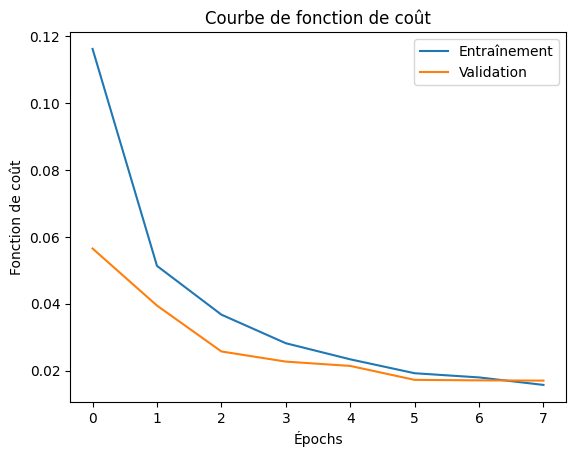

In [16]:
# Afficher les courbes de fonction de coût
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de fonction de coût')
plt.xlabel('Épochs')
plt.ylabel('Fonction de coût')
plt.legend()
plt.show()


In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1

# IV. Création du modèle d'ajustement

In [10]:
# Prendre le modèle à l'exception de la dernière couche qui classe en 4 classes
new_model = Model(inputs=model.input, outputs=model.layers[-2].output) #-4

# Geler toutes les couches
for layer in new_model.layers: #[:-3]
    layer.trainable=False

# Ajouter de nouvelles couches après les couches existantes
z = new_model.output
x = Flatten(name='flattened')(z)
x = Dropout(0.1, name='Dtop-fc1')(x)
x = Dense(128, activation='relu', name='top-fc1')(x)
x = Dense(128, activation='relu', name='top-fc2')(x)
x = Dropout(0.1, name='Dtop-fc2')(x)
predictions = Dense(10, name='dense_x8', activation='softmax')(x) #""""""

# Créer le modèle final en spécifiant ses entrées et sorties
final_model = Model(inputs=new_model.input, outputs=predictions)

# Vérifier les changements dans l'architecture du modèle
model = final_model
adam_optimizer = Adam(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=adam_optimizer, metrics=["accuracy"])

model.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization (Batch  (None, 28, 28, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0   

In [6]:
# Vérifier le statut "trainable" des couches
for layer in model.layers:
    print(layer.name, layer.trainable)

conv2d_input False
conv2d False
conv2d_1 False
batch_normalization False
max_pooling2d False
dropout False
conv2d_2 False
conv2d_3 False
batch_normalization_1 False
max_pooling2d_1 False
dropout_1 False
flatten False
dense False
dropout_2 False
flattened True
Dtop-fc1 True
top-fc1 True
top-fc2 True
Dtop-fc2 True
dense_x8 True


# V. Ajustement sur les 100 données annotées

In [11]:
#Reshaping inputs
X_labeled=X_labeled.reshape(-1, 28, 28, 1)
X_val=X_val.reshape(-1, 28, 28, 1)
X_test=X_test.reshape(-1, 28, 28, 1)

early_stop = EarlyStopping(monitor='val_loss',patience=2)
history=model.fit(X_labeled, y_labeled, validation_data=(X_val, y_val), epochs=30, callbacks=[early_stop])

Epoch 1/30


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4/4 [==============================] - 10s 3s/step - loss: 2.7806 - accuracy: 0.1300 - val_loss: 2.2606 - val_accuracy: 0.1576
Epoch 2/30
4/4 [==============================] - 10s 3s/step - loss: 2.1153 - accuracy: 0.2300 - val_loss: 2.1064 - val_accuracy: 0.3548
Epoch 3/30
4/4 [==============================] - 10s 3s/step - loss: 1.9051 - accuracy: 0.4300 - val_loss: 1.9842 - val_accuracy: 0.4594
Epoch 4/30
4/4 [==============================] - 10s 3s/step - loss: 1.8789 - accuracy: 0.4300 - val_loss: 1.8620 - val_accuracy: 0.5122
Epoch 5/30
4/4 [==============================] - 9s 3s/step - loss: 1.6628 - accuracy: 0.5800 - val_loss: 1.7394 - val_accuracy: 0.5572
Epoch 6/30
4/4 [==============================] - 10s 3s/step - loss: 1.5781 - accuracy: 0.5600 - val_loss: 1.6295 - val_accuracy: 0.5736
Epoch 7/30
4/4 [==============================] - 10s 3s/step - loss: 1.4662 - accuracy: 0.6100 - val_loss: 1.5258 - val_accuracy: 0.5862
Epoch 8/30
4/4 [==============================

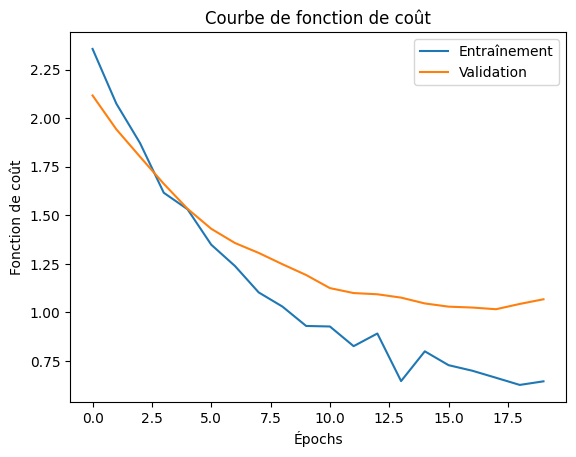

In [8]:
#Afficher les courbes de fonction de coût
plt.plot(history.history['loss'], label='Entraînement')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Courbe de fonction de coût')
plt.xlabel('Épochs')
plt.ylabel('Fonction de coût')
plt.legend()
plt.show()

# VI. Evaluation sur les données de test

## VI.I. Accuracy

In [13]:
# Évaluation sur les données de test
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Précision sur les données de test : {accuracy * 100:.2f}%")

157/157 [==============================] - 10s 63ms/step - loss: 0.7226 - accuracy: 0.8006
Précision sur les données de test : 80.06%


## VI.II. Classification report

In [9]:
y_true = y_test  
y_pred = np.argmax(model.predict(X_test), axis=1)  


report = classification_report(y_true, y_pred)
print(report)


  3/157 [..............................] - ETA: 6s 

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


157/157 [==============================] - 7s 43ms/step
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       520
           1       0.99      0.90      0.94       564
           2       0.90      0.92      0.91       502
           3       0.79      0.74      0.76       510
           4       0.82      0.87      0.84       482
           5       0.91      0.59      0.72       436
           6       0.75      0.93      0.83       496
           7       0.97      0.82      0.89       516
           8       0.59      0.50      0.54       485
           9       0.64      0.81      0.72       489

    accuracy                           0.81      5000
   macro avg       0.82      0.80      0.80      5000
weighted avg       0.82      0.81      0.81      5000



<Figure size 1000x600 with 0 Axes>

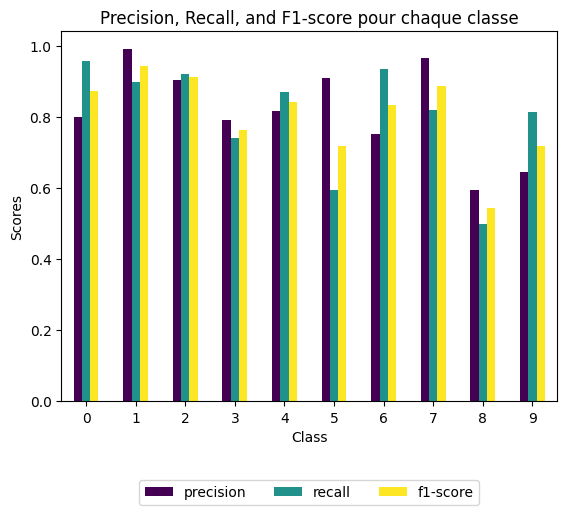

In [10]:
report = classification_report(y_true, y_pred, output_dict=True)
df = pd.DataFrame(report).transpose()

class_metrics = df[~df.index.isin(['accuracy', 'macro avg', 'weighted avg'])]


metrics = class_metrics.loc[:, ['precision', 'recall', 'f1-score']]


plt.figure(figsize=(10, 6))
metrics.plot(kind='bar', cmap='viridis', rot=0)
plt.title('Precision, Recall, and F1-score pour chaque classe')
plt.ylabel('Scores')
plt.xlabel('Class')
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3)
plt.show()

## VI.III. Matrice de confusion

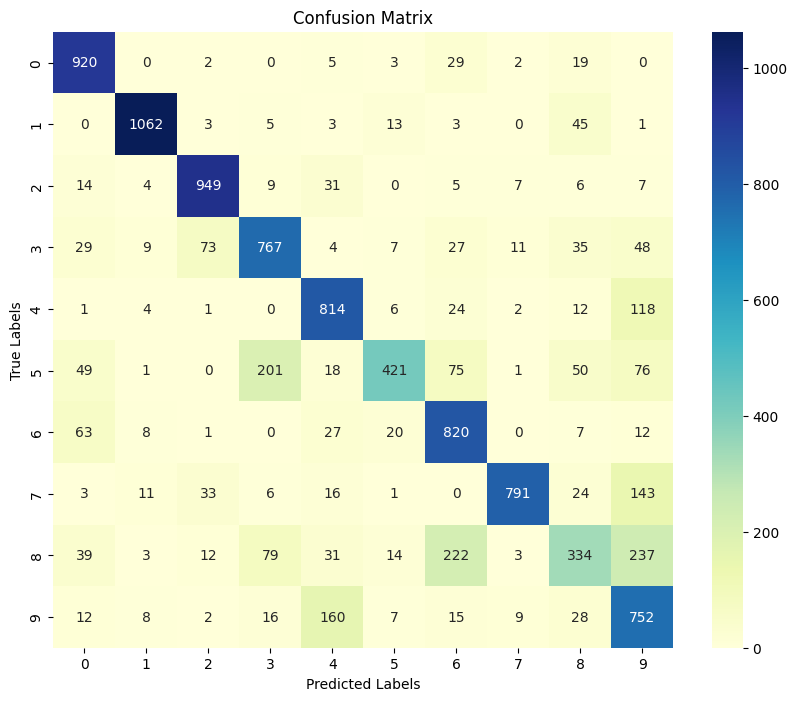

In [22]:
y_true_one_hot = to_categorical(y_test, 10)


conf_matrix = confusion_matrix(np.argmax(y_true_one_hot, axis=1), y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(  conf_matrix,
              annot=True,
              fmt='d',
              cmap='YlGnBu',
              cbar=True,
              xticklabels=range(10),
              yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## VI.IV. Interprétation

En évaluant sur l’ensemble de test, nous obtenons une accuracy de 80.06% à 81%, ce qui prouve l’efficacité de la méthode auto-supervisée. La matrice de confusion et le *classfication report* montre que pour chaque classe, le nombre de prédictions correctes est maximal par rapport aux autres prédictions, nous pouvons conclure que la méthode auto-supervisée pour la résolution.